# Map inversion and event sensitivities

In this notebook we experiment with the map inversion technique, implemented as detailed in the work:

*Martin Bertz* Modern Map Methods in Particle Beam Physics Academic Press (1999) pp.102 ([pdf](https://www.bmtdynamics.org/pub/papers/AIEP108book/AIEP108book.pdf))

The technique is of interest in the context of *heyoka* as it allows to invert efficiently systems of polynomial equations, for example the Taylor maps constructed from the variational equations.

In a [previous example](./ev_sensitivity.ipynb) we toyed with the idea of computing, for a generic event, the variations of its trigger time. In this notebook we set ourself the task to compute the very same thing for a generic system and eventually build Taylor maps relating the initial conditions to the final state at the event trigger time. We will need the map inversion algorithm to achieve our goals.

This is interesting, for example, in the context of planetary landing, sphere-of-influence entry condtions, Poincare' sections etc.. as it allows to propoagte efficiently uncertainties up to the event manifold, for example, using the machinery of the [moment generating functions](https://www.probabilitycourse.com/chapter6/6_1_3_moment_functions.php).

Let us get started with some necessary imports:

In [23]:
# Core imports
import heyoka as hy
import numpy as np
import matplotlib as plt
import math
from copy import deepcopy

# Plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Preamble

**How does the final state of a dynamical system vary when we perturb its initial conditions and parameters and the integration time is decided by a terminal event?**

We consider a generic set of ODEs:

$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = \mathbf f(\mathbf x) \\
\mathbf {x(0)} = \mathbf x_0
\end{array}
\right.
$$
and denote its solution as $\mathbf x(t, \mathbf x_0)$.

We now perform a numerical integration and stop at the time $T$ when some event condition $\mathbf e(\mathbf x(T, \mathbf x_0)) = \mathbf 0$ is satisfied. 

If we were to repeat the numerical integration from slightly perturbed initial conditions, the time at which the event would be triggered also will also be perturbed so that:
$$
\mathbf e\big(\mathbf x(T + \delta T, \mathbf x_0 + \delta \mathbf x_0)\big) = \mathbf 0
$$

In this notebook we will use *heyoka* to obtain polinomial expansions $\mathcal P$ of the final state and the event trigger time. That is, we seek to find:

$$
\left\{
\begin{array}{l}
\mathbf x_f = \mathcal P_{x_f}^n(\delta \mathbf x_0, \delta T)\\
\delta T = \mathcal P_T^n(\delta \mathbf x_0)
\end{array}
\right.
$$

This all may seem a bit complicated at this point, so it may help to imagine it before we start: we are building (in an automated fashion) high degree polinomials (also called Taylor maps) representing the sensitivities at the final event with respect to the initial conditions. 

We use, as an example, a particle subject to a gravity field and free falling up to when it collides with a spherical surface placed beneath it: **We want to describe the point where the particle collides with the sphere as a function of its initial state.**

Let us start to define our dynamical system $\mathbf f$:


In [2]:
# Create the symbolic variables for the state.
x, y, vx, vy = hy.make_vars("x", "y", "vx", "vy")
r = hy.sqrt(x**2 + y**2)

# The simple dynamics is described by the following:
dyn = [vx, vy, -1.0 / r**3 * x, -1.0 / r**3 * y]

# We assemble the system in the heyoka syntax
sys = []
sys.append((x, dyn[0]))
sys.append((y, dyn[1]))
sys.append((vx, dyn[2]))
sys.append((vy, dyn[3]))

and the event $\mathbf e$:

In [3]:
# Let us create the event
# Genric callback for a terminal event -> it does nothing except stopping the adaptive integrator when triggered.
def t_cb(ta, d_sgn):
    # Do stop the integration.
    return False


# Define a sphere of radius 1 (our planet :)
ev_expr = x**2 + y**2 - 1

# ... and the terminal event
t_ev = hy.t_event(
    # The event equation.
    ev_expr,
    # The callback.
    callback=t_cb,
)

We now construct a Taylor integrator with the defined event.


In [4]:
ta = hy.taylor_adaptive(sys, [0.1] * 4, compact_mode=True, t_events=[t_ev])

And test it on some nominal case

In [5]:
# Lets propagate
ic = [0.1, 2.3, 0.4, 0.1]
tof = 6.0

ta.state[:4] = ic

ta.time = 0.0
ta.reset_cooldowns()  # to be sure in case we evaluatre the cell twice in a row

t_grid_ta = np.linspace(0.0, tof)

out_ta = ta.propagate_grid(t_grid_ta)

trigger_time = ta.time
print("The event (hitting the sphere) triggers at: ", trigger_time)

The event (hitting the sphere) triggers at:  5.494381002478122


NOTE: The numerical propagation has terminated but, while the state of the *ta* object is the one at the event time trigger, the actual values contained in the array returned by *propagate_grid* miss this last point as its not on the requested grid. We thus create new variables and append there the necessary values.

In [6]:
out = np.vstack((out_ta[-1], ta.state.reshape(1, -1)))
t_grid = t_grid_ta[t_grid_ta < ta.time]
t_grid = np.hstack((t_grid, [ta.time]))

Lets have a look to the falling point:

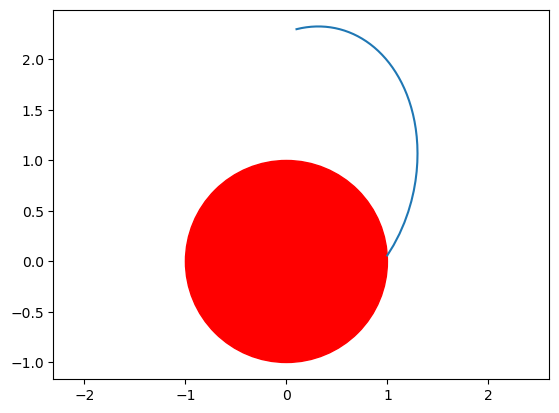

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(out[:, 0], out[:, 1])

circle = plt.Circle((0, 0), 1, color="r")
ax.add_patch(circle)
plt.axis("equal")

## Augmenting our system

Naturally, our object followed some kind of Keplerian orbit and stopped when it hit the sphere. So far so good. In order to understand where the object would hit the sphere should we change the initial conditions, we need to transform our set of ODEs applying a few tricks. 

We started from:

$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = v_x \\
\mathbf {\dot y} = v_y \\
\mathbf {\dot v_x} = - x/r^3 \\
\mathbf {\dot v_y} = - y/r^3 \\
\end{array}
\right.
$$

and the event $e = x^2 + y^2 -1 = 0$.

and we integrated up to the event rigger time $T$. Let us now, instead, consider the ODE system:
$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = T v_x \\
\mathbf {\dot y} = T v_y \\
\mathbf {\dot v_x} = - T x/r^3 \\
\mathbf {\dot v_y} = - T y/r^3 \\
\mathbf {\dot e} = T \nabla e \cdot \mathbf f
\end{array}
\right.
$$
with the added initial condition $e(t=0) = e(x_0, y_0, v_{x_0}, v_{y_0})$. We will integrate this system up to $t=1$, as we now consider the actual integration time as an ODE parameter. We also added one equation which will track the event value along the dynamics.

Using this augmented system of equations we build a variational integrator so that all high orders variations, including the ones w.r.t. $T$ will be computed:


In [8]:
# Auxiliary variable for the equation tracking the event
e = hy.make_vars("e")
# We compile the event function for later use
ev_cfunc = hy.cfunc([ev_expr], vars=[x, y, vx, vy])
# To compute the auxiliary equation we need the event gradient
ev_grad = hy.diff_tensors([ev_expr], diff_args=[x, y, vx, vy], diff_order=1).gradient

# We define the augmented system
sys_aug = []
sys_aug.append((x, hy.par[0] * dyn[0]))
sys_aug.append((y, hy.par[0] * dyn[1]))
sys_aug.append((vx, hy.par[0] * dyn[2]))
sys_aug.append((vy, hy.par[0] * dyn[3]))
sys_aug.append((e, hy.par[0] * np.dot(ev_grad, dyn)))

... and compute the variational system:

In [9]:
# Create the variational ODE system (symbolic).
vsys = hy.var_ode_sys(sys_aug, [x, y, vx, vy, e, hy.par[0]], order=4)

... and build the variational integrator:

In [10]:
# Construct the Taylor integrator containing also variational equations (llvm)
ta_var = hy.taylor_adaptive(vsys, [0.1] * 5, compact_mode=True)
# We store the initial conditions on the variational equations for future resets
ic_var = ta_var.state[5:]
print("Variational equations built, variations considered are: ", ta_var.vargs)

Variational equations built, variations considered are:  [x, y, vx, vy, e, p0]


We thus may now integrate this system up to a unitary time ($T$ is actually define what the real integration time is)

In [11]:
# Lets propagate
ic_aug = ic + [ev_cfunc(ic)[0]]

ta_var.state[:5] = ic_aug
ta_var.state[5:] = ic_var
ta_var.pars[:] = trigger_time

ta_var.time = 0.0

t_grid_ta_var = np.linspace(0.0, 1.0)

out_ta = ta_var.propagate_grid(t_grid_ta_var)

Just to verify, lets look at the value of $e$ at the end of our integration and check that is zero indeed:

In [12]:
print("The event state variable e value at the end is: ", ta_var.state[4])

The event state variable e value at the end is:  -8.673833409892439e-16


Here is perhaps a good place to stop for a second and try to understand what we have computed. Looking into how we defined and built the variational equations, it should be easy to see that calls to the method *eval_taylor_map* will use the following representations:


$$
\left\{
\begin{array}{l}
\delta x_f = \mathcal P_{x_f}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta T)\\
\delta y_f = \mathcal P_{y_f}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta T)\\
\delta v_{x_f} = \mathcal P_{v_{x_0}}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta T)\\
\delta v_{y_f} = \mathcal P_{v_{y_0}}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta T)\\
\delta e_f = \mathcal P_T^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta T)
\end{array}
\right.
$$

where $\mathcal P^n_\circ$ are multivariate polynomials of order $n$. Note that the variation w.r.t. the initial condition $e_0$ only appears in the last equation as that state variable does not affect any of the other equations (the ones referring to the original, non augmented, dynamics.)



Comparing this to what we wanted to compute we can see that we are getting very close, except the last equation, where we would rather have something
 like $\delta T = \mathcal P_T^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta e_f)$ to then set $\delta e_f=0$ and $\delta e_0 = e(\mathbf x_0+\delta \mathbf x_0) - e(\mathbf x_0)$.
 
To obtain this expression we need to invert the last equation!

# The map inversion algorithm

We need to write a few helper function as to be able to perform the map inversion in **heyoka.py**. Fistly we must be able to extract the symbolic epressions of the polynomials $\mathcal P^n_\circ$ from the various states of the variational equations. This is done via this simple helper, that returns alreay the quantities in the needed form:

In [13]:
# This extracts from the variational equations the Taylor maps (linear and non linear part separated) of states_id w.r.t. the vargs_id
def _extract_map(states_id, vargs_id, ta_var):
    # The linear part of the symbolic map
    M = [hy.expression(0)] * len(states_id)
    # The nonlinear part of the symbolic map
    N = [hy.expression(0)] * len(states_id)
    # The linear part of the numeric map
    matrix = np.zeros((len(states_id), len(vargs_id)))

    # 1 - We create the symbols for the polynomial system of equations: dx = P(dy)
    vargs_s = []
    for i in range(len(vargs_id)):
        vargs_s.append("dy" + str(i))
    vargs_e = hy.make_vars(*vargs_s)
    # In case vargs is only of len 1, the return value in heyoka changes type and is not a list.
    # We account for this case here
    if not isinstance(vargs_e, list):
        vargs_e = [vargs_e]

    # 3 - We loop over all mini indexes
    for i in range(ta_var.n_orig_sv, len(ta_var.sys)):
        mindex = ta_var.get_mindex(i)

        # If not, we only consider the term if it corresponds to a selected state
        if not (mindex[0] in states_id):
            continue
        # .. and contains only the selected vargs
        flag = 0.0
        for ii, jj in enumerate(mindex[1:]):
            if (not (ii in vargs_id)) and (jj > 0.0):
                flag = 1.0
                break

        if flag == 0:
            # At this point we know we need to add this term to the corresponding map.
            monomial = 1.0
            for k in range(len(vargs_id)):
                monomial *= vargs_e[k] ** mindex[vargs_id[k] + 1]
            value = ta_var.state[i]
            factorial = math.prod([math.factorial(_) for _ in mindex[1:]])

            value /= factorial
            if sum(mindex[1:]) == 1:
                M[states_id.index(mindex[0])] += value * monomial
                matrix[
                    states_id.index(mindex[0]), vargs_id.index(mindex[1:].index(1))
                ] = value
            else:
                N[states_id.index(mindex[0])] += value * monomial
    return matrix, M, N, vargs_e

We will also need to compose maps (the operator $\mathcal M_1\circ \mathcal M_2$ in the notation used by Berz in his book), ehch is a simple substituion, sum them and subtract them. For the purpose of this notebook a map $\mathcal M$ is an array of $n$ polynomials in the $m$ symbols $dy_0 ... dy_m$. The Map is square if $n=m$. The following functions are helpers doing just that:

In [14]:
# Map composition
def _map_composition_hy(A, B, symbols):
    tmp = deepcopy(A)
    for j in range(len(symbols)):
        tmp = hy.subs(tmp, {symbols[j]: B[j]})
    return tmp


# Map difference
def _map_difference(A, B):
    C = []
    for i in range(len(A)):
        C.append(A[i] - B[i])
    return C


# Map sum
def _map_sum(A, B):
    C = []
    for i in range(len(A)):
        C.append(A[i] + B[i])
    return C

Finally we can write the algorithm of map inversion:

In [15]:
# This inverts a Taylor map (square)
def invert_taylor_map(matrix, N, dy_e, order):
    dx_s = []
    for i in range(len(dy_e)):
        dx_s.append("dx" + str(i))
    dx_e = hy.make_vars(*dx_s)
    if not isinstance(dx_e, list):
        dx_e = [dx_e]

    Identity = dx_e
    # 2 - We assemple the linear part with 2 different symbols as to avoid nasty surprises in subs
    det = np.linalg.det(matrix)
    if abs(det) < 1e-10:
        raise ValueError("Linear Map is not invertible")
    Minv0 = list(np.linalg.inv(matrix) @ dx_e)  # dx symbols
    Minv02 = _map_composition_hy(Minv0, dy_e, dx_e)  # dy symbols
    # 3 - We iterate n times
    for i in range(order - 1):
        Minv0 = _map_composition_hy(
            Minv02, _map_difference(Identity, _map_composition_hy(N, Minv0, dy_e)), dy_e
        )
    cfunc = hy.cfunc(Minv0, vars=dx_e)
    return cfunc

## Using the map inversion 
We nw use the algorithm above to compute:

$$
\delta T = \mathcal P_T^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta e_f)
$$

from the expression available from the variational integrator:

$$
\delta e_f = \mathcal P_e^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta T)
$$

In [16]:
# First we extract the symbolic map of the event equation (id 4) w.r.t. the variations of all the six states+param (dT is the id 5)
matrix4, M4, N4, vargs_e = _extract_map([4], [0, 1, 2, 3, 4, 5], ta_var)

# Then we augment it wth identities as to obtain a sqaured map
M = [vargs_e[0], vargs_e[1], vargs_e[2], vargs_e[3], vargs_e[4], M4[0]]
N = [hy.expression(0)] * 5 + [N4[0]]
matrix = np.eye(6)
matrix[-1, :] = matrix4

# Finally we invert it
invmap = invert_taylor_map(matrix, N, vargs_e, ta_var.vorder)

Let us check if indeed we have succeded. 

We first compute the event trigger time change caused by some random change in the initial conditions from our inverse map (and using only its linear part)

In [17]:
size = 1e-2
d_ic = [
    np.random.random() * size,
    np.random.random() * size,
    np.random.random() * size,
    np.random.random() * size,
]
de0 = ev_cfunc(np.array(ic) + np.array(d_ic))[0] - ev_cfunc(np.array(ic))[0]
# We now use the random perturbation vector generated above (dx_0, dy_0, dvx_0, dvy_0) add de_f=0 and query the map for
# the change in event trigger time:
dT = invmap(d_ic + [de0, 0.0])
print("Event trigger time variation from the Taylor approximation:", dT[-1])
print(
    "Event trigger time variation from the Linear approximation:",
    (np.linalg.inv(matrix) @ (d_ic + [de0, 0.0]))[-1],
)

Event trigger time variation from the Taylor approximation: 0.16540565723252107
Event trigger time variation from the Linear approximation: 0.1597079162069765


Then we check the result via the fully non linear numercial propagation:

In [18]:
# Lets propagate using the original system (non augmented, non variational)
ic_new = np.array(ic) + np.array(d_ic)
tof = 6.0

ta.state[:4] = ic_new

ta.time = 0.0
ta.reset_cooldowns()

t_grid_ta = np.linspace(0.0, tof)

out_ta_new = ta.propagate_grid(t_grid_ta)

trigger_time_new = ta.time

print("Old event trigger time:", trigger_time)
print("New event trigger time:", trigger_time_new)
print(
    f"\nEvent trigger time difference:\t\t\t\t\t{trigger_time_new - trigger_time:.5e}"
)
print(f"Event trigger time difference from the Taylor approximation:\t{dT[-1]:.5e}\t")
print(
    "\nRelative error (on dT, not T): ",
    (dT[-1] - (trigger_time_new - trigger_time)) / (trigger_time_new - trigger_time),
)

Old event trigger time: 5.494381002478122
New event trigger time: 5.65978728556761

Event trigger time difference:					1.65406e-01
Event trigger time difference from the Taylor approximation:	1.65406e-01	

Relative error (on dT, not T):  -3.7837557016217055e-06


# Lets visualize the impact points

Our final aim was to have the variations of the final conditions, so we now produce 100 random variations of initial conditions, we compute via or Taylor maps the corresponding final conditions, which we expect all to lie on the sphere:

In [19]:
_, M, N, vargs_e = _extract_map([0, 1], [0, 1, 2, 3, 5], ta_var)
Map = _map_sum(M, N)
Map_cf = hy.cfunc(Map, vars=vargs_e)

In [20]:
dx = []
dy = []
dx0 = []
dy0 = []
for i in range(100):
    size = 1e-1
    d_ic = [
        (0.5 - np.random.random()) * size,
        (0.5 - np.random.random()) * size,
        (0.5 - np.random.random()) * size,
        (0.5 - np.random.random()) * size,
    ]
    de0 = ev_cfunc(np.array(ic) + np.array(d_ic))[0] - ev_cfunc(np.array(ic))[0]
    dT = invmap(d_ic + [de0, 0.0])[-1]
    tmp = Map_cf(d_ic + [dT])
    dx.append(tmp[0])
    dy.append(tmp[1])
    dx0.append(d_ic[0])
    dy0.append(d_ic[1])

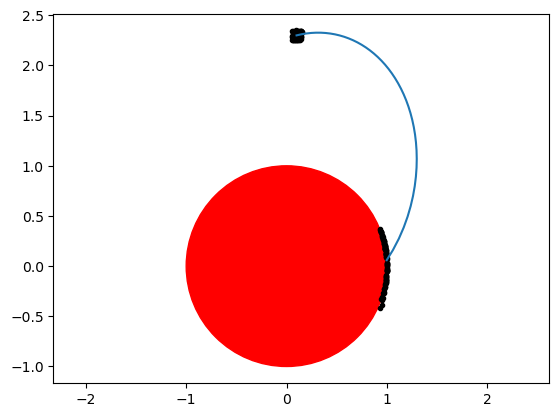

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(out[:, 0], out[:, 1])

circle = plt.Circle((0, 0), 1, color="r")
ax.add_patch(circle)
plt.axis("equal")

plt.scatter(out[0, 0] + dx0, out[0, 1] + dy0, marker=".", color="k")
plt.scatter(out[-1, 0] + dx, out[-1, 1] + dy, marker=".", color="k")

Eureka!!! Thats all folks!.